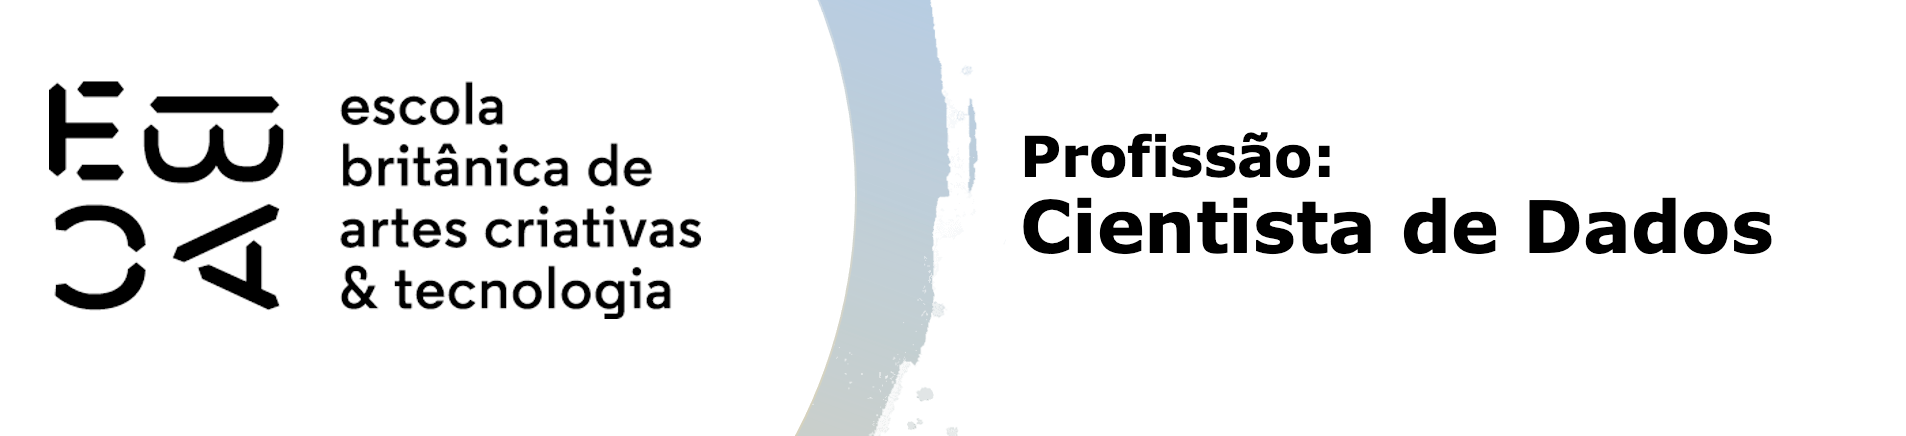

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import t
from scipy.stats import ks_2samp


df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
print('numero de linhas: {0} \nnúmero de colunas: {1}'.format(df.shape[0], df.shape[1]))
df.mau.value_counts(normalize=True)

numero de linhas: 750000 
número de colunas: 15


mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

In [5]:
df.mau.value_counts()

mau
False    691357
True      58643
Name: count, dtype: int64

In [6]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [7]:
# Transformei a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [9]:
# Transformei o data_ref como datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Meses únicos disponíveis
meses_disponiveis = df['data_ref'].sort_values().unique()
print("Meses disponíveis:", meses_disponiveis)

Meses disponíveis: <DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]


In [10]:
# Seleçao dos 3 últimos meses como OOT
ultimos_3_meses = df['data_ref'].sort_values().drop_duplicates().tail(3)
print("Safra OOT (3 últimos meses):")
print(ultimos_3_meses)

Safra OOT (3 últimos meses):
633328   2016-01-01
683336   2016-02-01
733333   2016-03-01
Name: data_ref, dtype: datetime64[ns]


In [11]:
# Separaçao da base OOT e a base de modelagem (treino/validação)
df_oot = df[df['data_ref'].isin(ultimos_3_meses)].copy()
df_modelagem = df[~df['data_ref'].isin(ultimos_3_meses)].copy()

df_modelagem = df_modelagem.dropna()
df_oot = df_oot.dropna()

print(f"Tamanho total: {df.shape[0]}")
print(f"Base de modelagem (treino/OOS): {df_modelagem.shape[0]}")
print(f"Base OOT (validação final): {df_oot.shape[0]}")

Tamanho total: 750000
Base de modelagem (treino/OOS): 499125
Base OOT (validação final): 124918


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [13]:
# Total de linhas
print("Número total de linhas:", df.shape[0])

# Número de linhas por mês em data_ref
print("Número de linhas por mês (safra):")
print(df['data_ref'].value_counts().sort_index())


Número total de linhas: 750000
Número de linhas por mês (safra):
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [14]:
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego',
                           'qt_pessoas_residencia', 'renda']

In [15]:
print("Estatísticas descritivas - Variáveis Quantitativas:")
df[variaveis_quantitativas].describe()

Estatísticas descritivas - Variáveis Quantitativas:


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04
std,0.739379,11.229868,6.687455,0.903428,7.910601e+04
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


In [16]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                          'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

In [17]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv_sexo = IV(df.sexo, df.mau)
iv_posse_de_veiculo = IV(df.posse_de_veiculo, df.mau)
iv_posse_de_imovel = IV(df.posse_de_imovel, df.mau)
iv_tipo_renda = IV(df.tipo_renda, df.mau)
iv_educacao = IV(df.educacao, df.mau)
iv_estado_civil = IV(df.estado_civil, df.mau)
iv_tipo_residencia = IV(df.tipo_residencia, df.mau)

print(f'IV da variável sexo: {iv_sexo:.1%}')
print(f'IV da variável posse_de_veiculo: {iv_posse_de_veiculo:.1%}')
print(f'IV da variável posse_de_imovel: {iv_posse_de_imovel:.1%}')
print(f'IV da variável tipo_renda: {iv_tipo_renda:.1%}')
print(f'IV da variável educacao: {iv_educacao:.1%}')
print(f'IV da variável estado_civil: {iv_estado_civil:.1%}')
print(f'IV da variável tipo_residencia: {iv_tipo_residencia:.1%}')

IV da variável sexo: 0.2%
IV da variável posse_de_veiculo: 0.0%
IV da variável posse_de_imovel: 1.0%
IV da variável tipo_renda: 0.9%
IV da variável educacao: 0.4%
IV da variável estado_civil: 0.1%
IV da variável tipo_residencia: 0.3%


In [18]:
# Criei metadados para melhor analise das variaveis
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,15.0,covariavel
index,int64,0.0,16650.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


In [19]:
# Calculo do IV no metadados
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
index,int64,0.0,16650.0,covariavel,0.002664
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [21]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

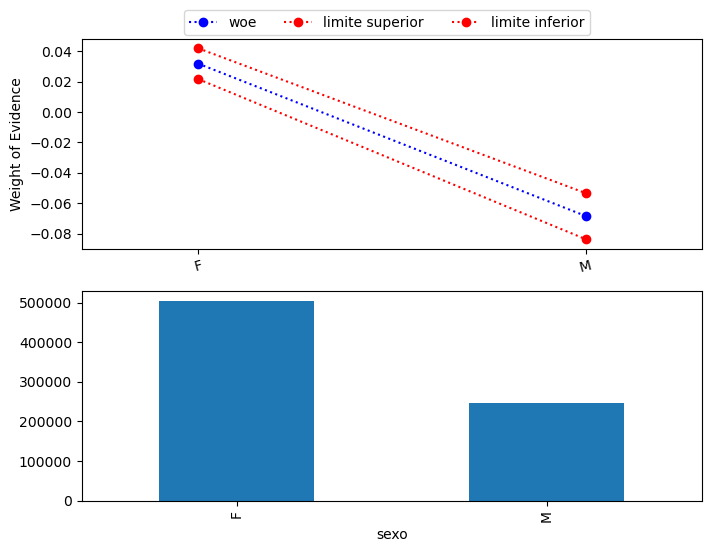

In [22]:
biv_discreta('sexo', df);

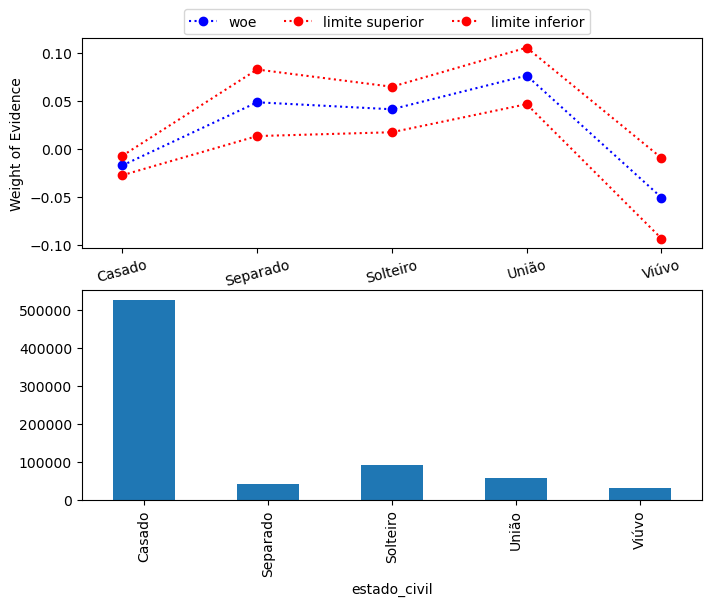

In [23]:
biv_discreta('estado_civil', df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Bolsista,346,15,0.041551,Bolsista,361,0.010503,0.062207,0.020896,-3.138389,-2.713068,-3.847087,-0.671200,-0.245880,-1.379899
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Servidor público,61151,3771,0.058085,Servidor público,64922,0.000918,0.059884,0.056286,-2.786006,-2.753587,-2.819381,-0.318818,-0.286399,-0.352193


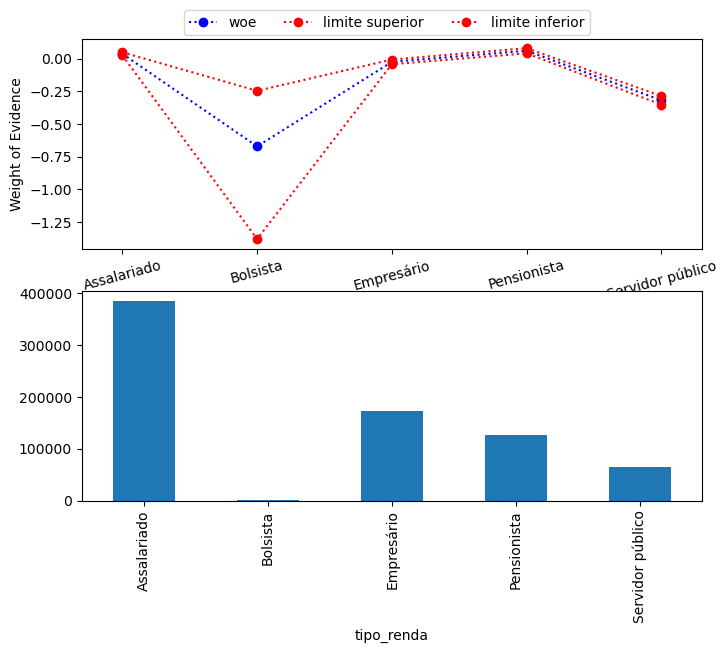

In [24]:
biv_discreta('tipo_renda', df)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,Fundamental,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Médio,466106,40730,0.080361,Médio,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Pós graduação,753,59,0.072660,Pós graduação,812,0.009109,0.090541,0.054779,-2.546528,-2.307049,-2.848105,-0.079340,0.160139,-0.380917
Superior completo,189684,14622,0.071569,Superior completo,204306,0.000570,0.072687,0.070451,-2.562832,-2.546130,-2.579777,-0.095644,-0.078942,-0.112588
Superior incompleto,27025,2446,0.082997,Superior incompleto,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


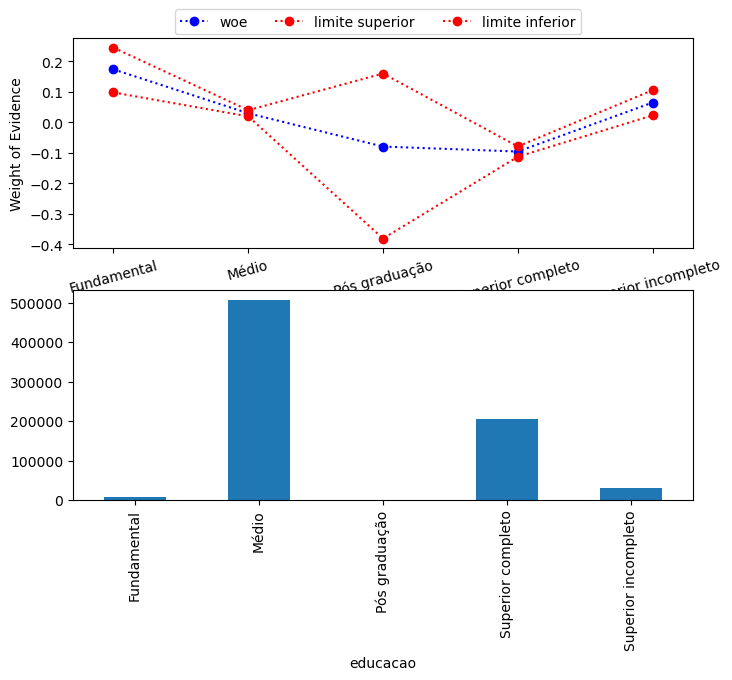

In [25]:
biv_discreta('educacao', df)

In [26]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\AJWork\AppData\Local\Temp\ipykernel_11168\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


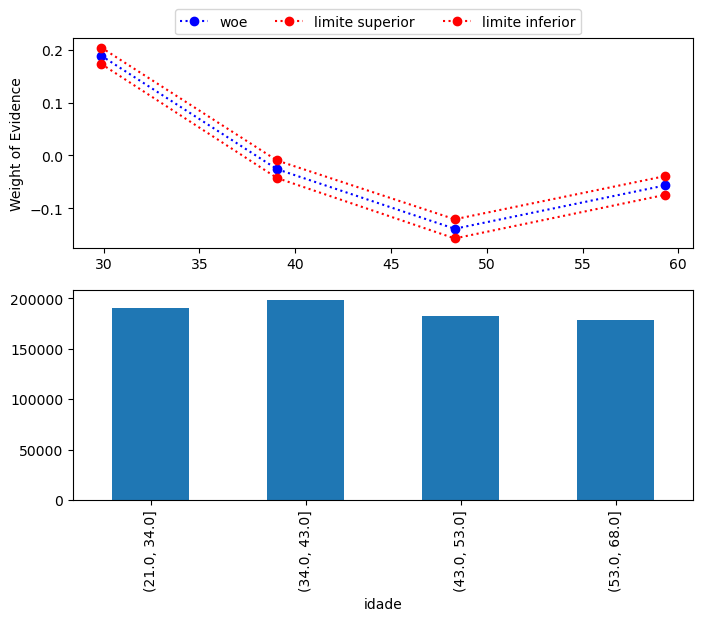

In [27]:
biv_continua('idade', 4, df)

In [28]:
df.columns
df.tempo_emprego.describe()

count    624043.000000
mean          7.748574
std           6.687455
min           0.117808
25%           3.049315
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64

C:\Users\AJWork\AppData\Local\Temp\ipykernel_11168\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


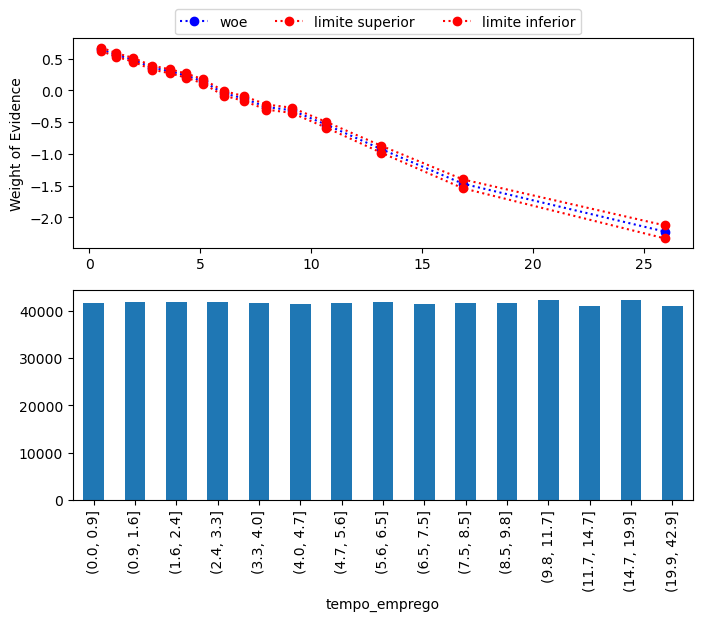

In [29]:
df.loc[df['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [31]:
df.isna().mean()

data_ref                 0.000000
index                    0.000000
sexo                     0.000000
posse_de_veiculo         0.000000
posse_de_imovel          0.000000
qtd_filhos               0.000000
tipo_renda               0.000000
educacao                 0.000000
estado_civil             0.000000
tipo_residencia          0.000000
idade                    0.000000
tempo_emprego            0.167943
qt_pessoas_residencia    0.000000
renda                    0.000000
mau                      0.000000
bom                      0.000000
dtype: float64

In [32]:
df["tempo_emprego"].fillna(-1, inplace=True)

C:\Users\AJWork\AppData\Local\Temp\ipykernel_11168\869726475.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["tempo_emprego"].fillna(-1, inplace=True)


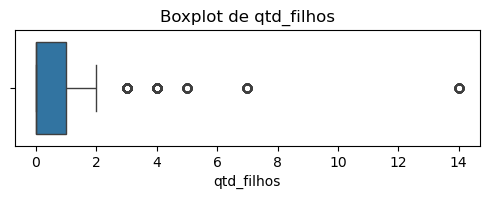

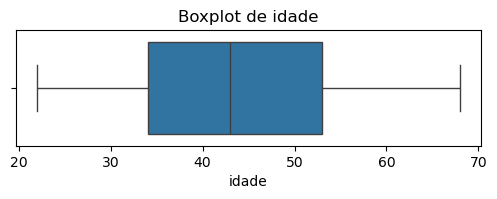

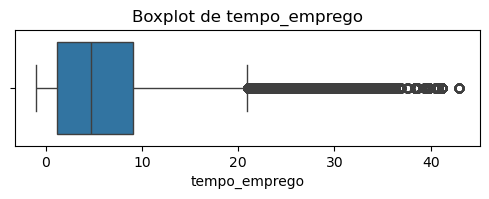

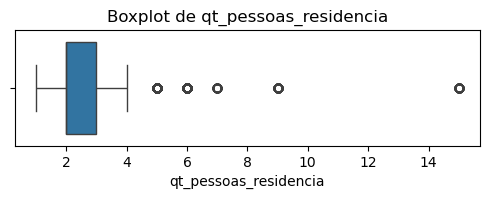

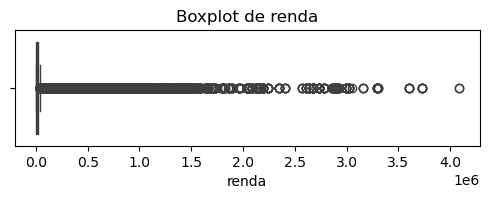

In [33]:
for col in variaveis_quantitativas:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

In [34]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,142419.0,covariavel,1.068628
tempo_emprego,float64,125957.0,3004.0,covariavel,0.351920
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
idade,int64,0.0,47.0,covariavel,0.017968
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
tipo_residencia,object,0.0,6.0,covariavel,0.003045
index,int64,0.0,16650.0,covariavel,0.002664
sexo,object,0.0,2.0,covariavel,0.002185


In [35]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + data_ref + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + index + sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos + mau + bom'

In [36]:
# Selecionei as variaveis com maiores valores IV:
formula = '''
    mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda
'''

rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               750000
Model:                            GLM   Df Residuals:                   749991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8372e+05
Date:                Tue, 25 Mar 2025   Deviance:                   3.6724e+05
Time:                        02:10:46   Pearson chi2:                 4.66e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.05704
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.2680      0.022    -58.249      0.000      -1.311      -1.225
posse_de_imovel[T.S]              -0.0892      0.009     -9.622      0.000      -0.107      -0.071
tipo_renda[T.Bolsista]            -0.1738      0.268     -0.648      0.517      -0.700       0.352
tipo_renda[T.Empresário]          -0.0466      0.011     -4.193      0.000      -0.068      -0.025
tipo_renda[T.Pensionista]         -0.2405      0.018    -13.247      0.000      -0.276      -0.205
tipo_renda[T.Servidor público]    -0.0335      0.018     -1.819      0.069      -0.070       0.003
renda                             -0.0001   1.05e-06   -122.586      0.000      -0.000      -0.000
tempo_emprego                     -0.0264      0.001    -19.003      0.000      -0.029      -0.024
idade                              0.0006      0.001      1.140      0.254      -0.000       0.002
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [38]:
# Gerando previsões
df_modelagem.loc[:, "score"] = rl.predict(df_modelagem)
df_oot.loc[:, "score"] = rl.predict(df_oot)

# Avaliação
def avaliar(df, nome_base):
    y_true = df["mau"]
    y_score = df["score"]
    y_pred = (y_score > 0.5).astype(int)

    acc = metrics.accuracy_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.auc(fpr, tpr)
    gini = 2 * auc - 1
    ks = ks_2samp(df[df.mau == 1]["score"], df[df.mau == 0]["score"]).statistic

    return {
        "Base": nome_base,
        "Acurácia": acc,
        "AUC": auc,
        "Gini": gini,
        "KS": ks
    }

# Avaliaçao ambas as bases
resultado_modelagem = avaliar(df_modelagem, "Desenvolvimento")
resultado_oot = avaliar(df_oot, "Out of Time")

# Resultados
resultados = pd.DataFrame([resultado_modelagem, resultado_oot])
resultados

,Base,Acurácia,AUC,Gini,KS
0,Desenvolvimento,0.939564,0.775626,0.551251,0.408485
1,Out of Time,0.855329,0.739276,0.478553,0.351114


## Conclusão:

O modelo de regressão logística desenvolvido para prever inadimplência demonstrou bom desempenho preditivo tanto na base de desenvolvimento quanto na base de validação out-of-time (OOT), o que indica capacidade de generalização: 
- O modelo consegue diferenciar bem bons e maus pagadores (AUC > 0.7 em ambas as bases)
- A estabilidade entre as bases indica que o modelo não sofreu overfitting
- Gini de 0.55 na base de desenvolvimento e 0.48 na OOT → mostra um modelo forte, estável e confiável
- O KS > 0.3 nas duas bases reforça o bom poder discriminante
